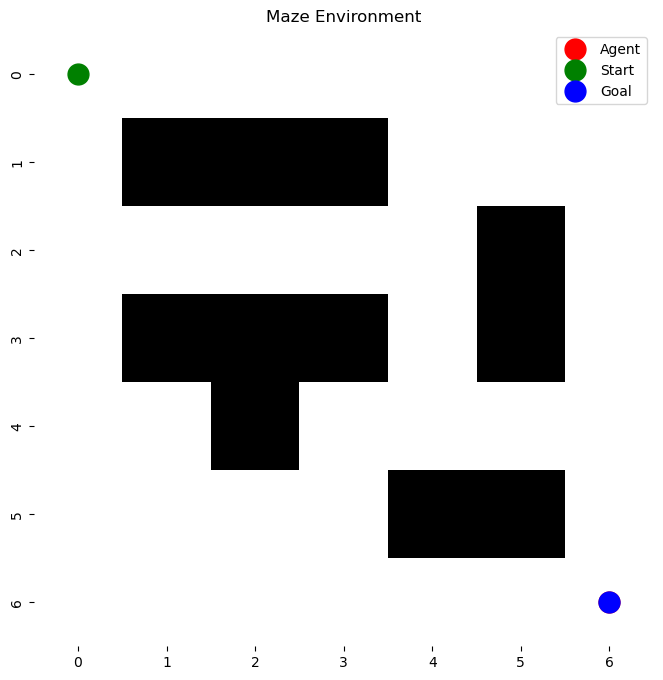

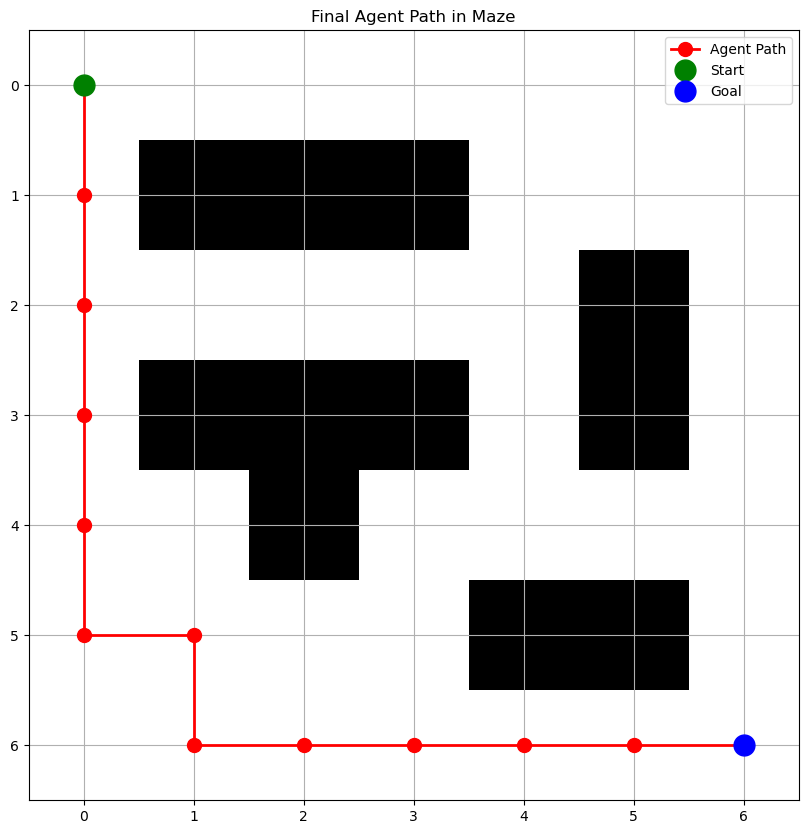

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

class MazeEnvironment:
    def __init__(self, size=7):
        self.size = size
        self.maze = np.full((size, size), ' ')
        # Define start, goal, and walls
        self.maze[0, 0] = 'S'  # Start
        self.maze[size-1, size-1] = 'G'  # Goal
        
        # Add some walls (W) - you can modify this pattern
        wall_positions = [
            (1, 1), (1, 2), (1, 3), (3, 1), (3, 2), (3, 3),
            (5, 4), (5, 5), (2, 5), (3, 5), (4, 2)
        ]
        for pos in wall_positions:
            self.maze[pos] = 'W'
        
        self.state = (0, 0)  # Current position
        self.actions = ['up', 'right', 'down', 'left']
        
    def reset(self):
        self.state = (0, 0)
        return self.state
    
    def get_possible_actions(self):
        return self.actions
    
    def step(self, action):
        current_row, current_col = self.state
        next_row, next_col = current_row, current_col
        
        # Determine next position based on action
        if action == 'up':
            next_row = max(0, current_row - 1)
        elif action == 'down':
            next_row = min(self.size - 1, current_row + 1)
        elif action == 'left':
            next_col = max(0, current_col - 1)
        elif action == 'right':
            next_col = min(self.size - 1, current_col + 1)
            
        # Check if next position is a wall
        if self.maze[next_row, next_col] == 'W':
            reward = -10  # Penalty for hitting wall
            return self.state, reward, False
            
        # Update state
        self.state = (next_row, next_col)
        
        # Check if reached goal
        if self.maze[next_row, next_col] == 'G':
            reward = 100  # Reward for reaching goal
            done = True
        else:
            reward = -1  # Small penalty for each step
            done = False
            
        return self.state, reward, done
    
    def render(self):
        plt.figure(figsize=(8, 8))
        sns.heatmap(self.maze == 'W', cmap='binary', cbar=False)
        plt.plot(self.state[1] + 0.5, self.state[0] + 0.5, 'ro', markersize=15, label='Agent')
        plt.plot(0.5, 0.5, 'go', markersize=15, label='Start')
        plt.plot(self.size - 0.5, self.size - 0.5, 'bo', markersize=15, label='Goal')
        plt.legend()
        plt.title('Maze Environment')
        plt.show()
        
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = {}
        self.initialize_q_table()
        
    def initialize_q_table(self):
        for i in range(self.env.size):
            for j in range(self.env.size):
                self.q_table[(i, j)] = {action: 0.0 for action in self.env.actions}
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)
        return max(self.q_table[state].items(), key=lambda x: x[1])[0]
    
    def learn(self, state, action, reward, next_state):
        best_next_action = max(self.q_table[next_state].items(), key=lambda x: x[1])[0]
        best_next_value = self.q_table[next_state][best_next_action]
        
        # Q-learning update
        self.q_table[state][action] = self.q_table[state][action] + \
            self.lr * (reward + self.gamma * best_next_value - self.q_table[state][action])

def train_and_visualize(episodes=1000):
    env = MazeEnvironment()
    agent = QLearningAgent(env)
    rewards_history = []
    
    # Training phase
    print("Starting training...")
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            
        rewards_history.append(total_reward)
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Average Reward: {np.mean(rewards_history[-100:]):.2f}")
    
    print("Training completed.")
    
    # Plot learning curves
    plt.figure(figsize=(12, 6))
    
    # Cumulative rewards plot
    plt.subplot(1, 2, 1)
    cumulative_rewards = np.cumsum(rewards_history)
    plt.plot(cumulative_rewards, 'b-', label='Cumulative Reward')
    plt.title('Cumulative Reward Over Episodes')
    plt.xlabel('Episode Number')
    plt.ylabel('Cumulative Reward')
    plt.grid(True)
    plt.legend()
    
    # Moving average plot
    plt.subplot(1, 2, 2)
    window_size = 100
    moving_avg = np.convolve(rewards_history, 
                            np.ones(window_size)/window_size, 
                            mode='valid')
    plt.plot(moving_avg, 'r-', label=f'Moving Average ({window_size} episodes)')
    plt.title('Moving Average of Rewards')
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Wait for user input before showing the maze visualization
    input("\nPress Enter to show the optimal path visualization...")
    
    # Visualize optimal path
    print("\nShowing optimal path...")
    env = MazeEnvironment()
    state = env.reset()
    done = False
    
    while not done:
        env.render()
        action = agent.choose_action(state)
        state, reward, done = env.step(action)
        clear_output(wait=True)
        time.sleep(0.5)
    
    env.render()
    
    return agent, rewards_history

# Run the training and visualization
agent, rewards_history = train_and_visualize()

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(rewards_history)
plt.title('Learning Curve')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

def visualize_optimal_path():
    env = MazeEnvironment()
    state = env.reset()
    done = False
    
    while not done:
        env.render()
        action = agent.choose_action(state)
        state, reward, done = env.step(action)
        clear_output(wait=True)
        time.sleep(0.5)
    
    env.render()
    
def visualize_final_path():
    env = MazeEnvironment()
    state = env.reset()
    done = False
    path = [state]  # For storing complete path
    
    # Find complete path
    while not done:
        action = agent.choose_action(state)
        state, reward, done = env.step(action)
        path.append(state)
    
    # Visualize final path
    plt.figure(figsize=(10, 10))
    
    # Show walls
    maze_array = (env.maze == 'W').astype(float)
    plt.imshow(maze_array, cmap='binary')
    
    # Show traversed path
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], 'r-o', linewidth=2, markersize=10, label='Agent Path')
    
    # Show start and end points
    plt.plot(0, 0, 'go', markersize=15, label='Start')
    plt.plot(env.size-1, env.size-1, 'bo', markersize=15, label='Goal')
    
    plt.grid(True)
    plt.title('Final Agent Path in Maze')
    plt.legend()
    plt.show()

visualize_optimal_path()
visualize_final_path()